In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import tqdm
import random
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

In [2]:
random.seed(42)

In [3]:
ecg_mat = scipy.io.loadmat('ECGData.mat')

In [4]:
ecg_data = ecg_mat['ECGData'][0][0][0]
print(ecg_data.shape)

(162, 65536)


In [5]:
labels = ecg_mat['ECGData'][0][0][1]
print(labels.shape)

(162, 1)


In [6]:
def split_dataset_indices(N, train_percent, val_percent, test_percent, seed=42):
    # Validate input percentages
    if train_percent + val_percent + test_percent != 100:
        raise ValueError("The sum of the percentages must be 100.")

    random.seed(seed)
    # Generate a list of indices
    indices = list(range(N))
    random.shuffle(indices)

    # Calculate split sizes
    train_size = int((train_percent / 100) * N)
    val_size = int((val_percent / 100) * N)

    # Split indices
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size + val_size]
    test_indices = indices[train_size + val_size:]

    return train_indices, val_indices, test_indices

In [7]:
train_indices, val_indices, test_indices = split_dataset_indices(labels.shape[0], 70, 15, 15)

In [53]:
def create_windowed_dataset(data, labels, window_size=1024, stride=None):
    if not stride:
        stride = window_size

    min_val = np.min(data, axis=(0, 1), keepdims=True)
    max_val = np.max(data, axis=(0, 1), keepdims=True)
    data = 2 * ((data - min_val) / (max_val - min_val)) - 1
    
    num_samples, sample_size = data.shape
    num_windows = sample_size // window_size
    
    # Initialize the windowed data and label arrays
    windowed_data = np.empty((num_samples * num_windows, window_size))
    windowed_labels = np.empty((num_samples * num_windows, 1), dtype=labels.dtype)

    for i in range(num_samples):
        for j in range(num_windows):
            start = j * stride
            end = start + window_size
            windowed_data[i * num_windows + j, :] = data[i, start:end]
            windowed_labels[i * num_windows + j, :] = labels[i]

    return np.expand_dims(windowed_data, -1), windowed_labels

In [54]:
ecg_t, labels_t = create_windowed_dataset(ecg_data[train_indices], labels[train_indices], window_size=1024)
ecg_v, labels_v = create_windowed_dataset(ecg_data[val_indices], labels[val_indices], window_size=1024)

In [55]:
ecg_t.shape # (n, h, c) for keras

(7232, 1024, 1)

In [56]:
ecg_v.shape

(1536, 1024, 1)

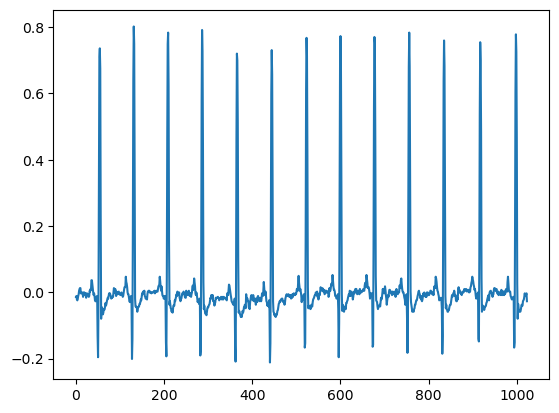

In [58]:
plt.plot(ecg_v[0, :, 0])

In [13]:
keras.utils.set_random_seed(42)

In [157]:
# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 16
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (1024, 1)
NUM_CLASSES = 10

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 100

# AUGMENTATION
IMAGE_SIZE = 1024  # We will resize input images to this size.
PATCH_SIZE = 64  # Size of the patches to be extracted from the input images.
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE)
MASK_PROPORTION = 0.50  # We have found 75% masking to give us the best results.

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 12
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    6  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

In [158]:
class Patches(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

        # Assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3).
        self.resize = layers.Reshape((-1, patch_size))

    def call(self, images):
        # Create patches from the input images

        # we have input of size (n, h, c), we want (n, h, 1, c) so we can use the image utilities
        n, h, c = images.shape

        images = tf.expand_dims(images, axis=-1)

        assert h % self.patch_size == 0, f'time-series of size {h} must be divisible by patch size {self.patch_size}'
        
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, 1, 1],
            strides=[1, self.patch_size, 1, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )

        # Reshape the patches to (batch, num_patches, patch_area) and return it.
        # this should be (n, h//patch_size, patch_size)
        patches = self.resize(patches)
        n_new, num_patches, patch_area = patches.shape
        assert n_new == n, f'Expected batch size {n} does not match actual {n_new}'
        assert num_patches == (h // self.patch_size), f'Expected number of patches {h//self.patch_size} does not match actual {num_patches}'
        assert patch_area == self.patch_size, f'Expected patch size {self.patch_size} does not match actual {patch_area}'
        return patches

    def show_patched_series(self, series, patches):
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")
    
        plt.figure(figsize=(10, 2))
        plt.plot(series[idx])
        plt.show()
    
        n = patches.shape[1]
        plt.figure(figsize=(10, 2))
    
        global_min = np.min(patches[idx])
        global_max = np.max(patches[idx])
    
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(1, n, i + 1)
            patch_series = tf.reshape(patch, (self.patch_size,))
    
            # Adjust x values to indicate location in original series
            x_values = np.arange(i * self.patch_size, (i + 1) * self.patch_size)
            plt.plot(x_values, patch_series)
    
            # Normalize y-axis scale across all patches
            plt.ylim(global_min, global_max)
    
            # Only display y axis on the first patch
            if i != 0:
                plt.tick_params(labelleft=False)
                
            plt.xticks(rotation='vertical')
    
        plt.show()
    
        return idx

    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patches(self, patches):
        # This utility function takes patches from a *single* series and
        # reconstructs it back into the series. This is useful for the train
        # monitor callback.
        num_patches = patches.shape[0]
        patches = tf.reshape(patches, (num_patches * self.patch_size, 1))
        reconstructed = tf.concat(patches, axis=0)
        return reconstructed

(1536, 16, 64)
Index selected: 1478.


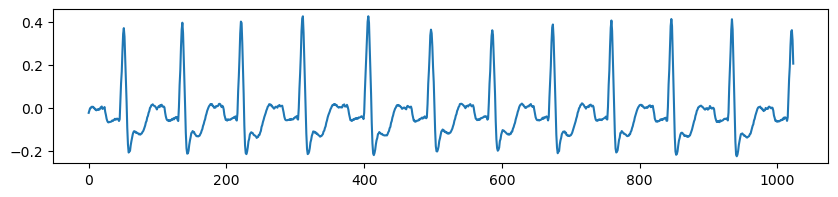

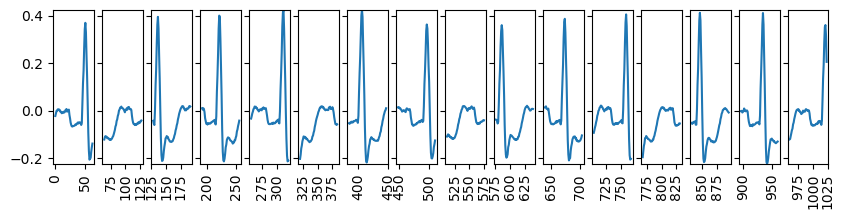

1478

In [159]:
p = Patches()
res = p(ecg_v)
print(res.shape)
p.show_patched_series(ecg_v, res)

In [160]:
first_reconstructed = p.reconstruct_from_patches(res[0])
print(ecg_v[0].shape)
print(first_reconstructed.shape)
assert np.allclose(ecg_v[0], first_reconstructed), 'Reconstructed time-series from patches does not match original'

(1024, 1)
(1024, 1)


In [161]:
class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        # Create the projection layer for the patches.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

        # Number of patches that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        # Get the positional embeddings.
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches.
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

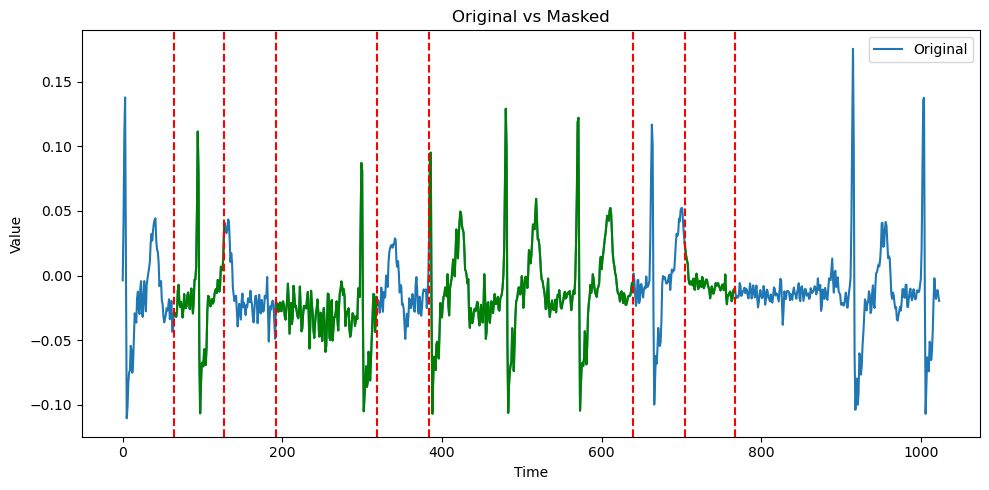

In [162]:
import matplotlib.pyplot as plt

# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=res)

# Show a masked patch image.
new_patch, random_index = patch_encoder.generate_masked_image(res, unmask_indices)

# Convert patches back to time series data
masked_series = p.reconstruct_from_patches(new_patch)
original_series = p.reconstruct_from_patches(res[random_index])

plt.figure(figsize=(10, 5))

# Plot original time series
plt.plot(original_series[:, 0], label="Original")
plt.title("Original vs Masked")
plt.xlabel("Time")
plt.ylabel("Value")

# Plot masked time series
masked_series_flat = tf.reshape(masked_series, [-1])
non_zero_indices = tf.where(masked_series_flat != 0)
non_zero_indices = tf.reshape(non_zero_indices, [-1])  # Convert to 1D tensor
non_zero_values = tf.gather(masked_series_flat, non_zero_indices)  # Gather elements at non_zero_indices

# Split non_zero_indices and non_zero_values into continuous segments and plot each segment separately
diff = np.diff(non_zero_indices)
segments = np.where(diff != 1)[0] + 1
segments = np.concatenate(([0], segments, [len(non_zero_indices)]))

for i in range(len(segments) - 1):
    start, end = segments[i], segments[i+1]
    plt.plot(non_zero_indices[start:end], non_zero_values[start:end], 'g')

    # Add vertical lines at the start and end of each contiguous patch
    plt.axvline(non_zero_indices[start], color='r', linestyle='--')
    plt.axvline(non_zero_indices[end-1], color='r', linestyle='--')


plt.legend()
plt.tight_layout()
plt.show()

In [163]:
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [164]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

In [165]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size, activation="sigmoid")(x)
    outputs = layers.Reshape((image_size, 1))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")


In [166]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        augmented_images = images # no augmentation
        
        # Patch the augmented images.
        patches = self.patch_layer(augmented_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compute_loss(y=loss_patch, y_pred=loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for grad, var in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        results = {}
        for metric in self.metrics:
            metric.update_state(loss_patch, loss_output)
            results[metric.name] = metric.result()
        return results

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)

        # Update the trackers.
        results = {}
        for metric in self.metrics:
            metric.update_state(loss_patch, loss_output)
            results[metric.name] = metric.result()
        return results

In [167]:
def plot_results(original_image, masked_image, reconstructed_image):
    # Assuming original_image, masked_image and reconstructed_image are numpy arrays
    plt.figure(figsize=(12, 6))
    
    # Plot original image
    plt.plot(original_image, label='Original Image')
    
    # Plot masked image
    plt.plot(masked_image, label='Masked Image')
    
    # Plot reconstructed image
    plt.plot(reconstructed_image, label='Reconstructed Image')
    
    plt.legend()  # Show legend
    plt.show()  # Display the plot
    plt.close()

In [168]:
class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_patches = self.model.patch_layer(ecg_v)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = ecg_v[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patches(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            plot_results(original_image, masked_image, reconstructed_image)

            print(f'original image: {original_image.shape}')
            print(f'masked image: {masked_image.shape}')
            print(f'reconstructed image: {reconstructed_image.shape}')

In [169]:
patch_layer = Patches()
patch_encoder = PatchEncoder()

In [170]:
encoder = create_encoder()

In [171]:
decoder = create_decoder(image_size=1024)

In [172]:
mae_model = MaskedAutoencoder(
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

In [173]:
train_ds = tf.data.Dataset.from_tensor_slices(ecg_t)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices(ecg_v)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

Epoch 1/100


2023-12-17 11:09:54.408625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [7232,1024,1]
	 [[{{node Placeholder/_0}}]]


452/452 [==============================] - ETA: 0s - loss: 0.0355

2023-12-17 11:10:20.246953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1536,1024,1]
	 [[{{node Placeholder/_0}}]]



Idx chosen: 508


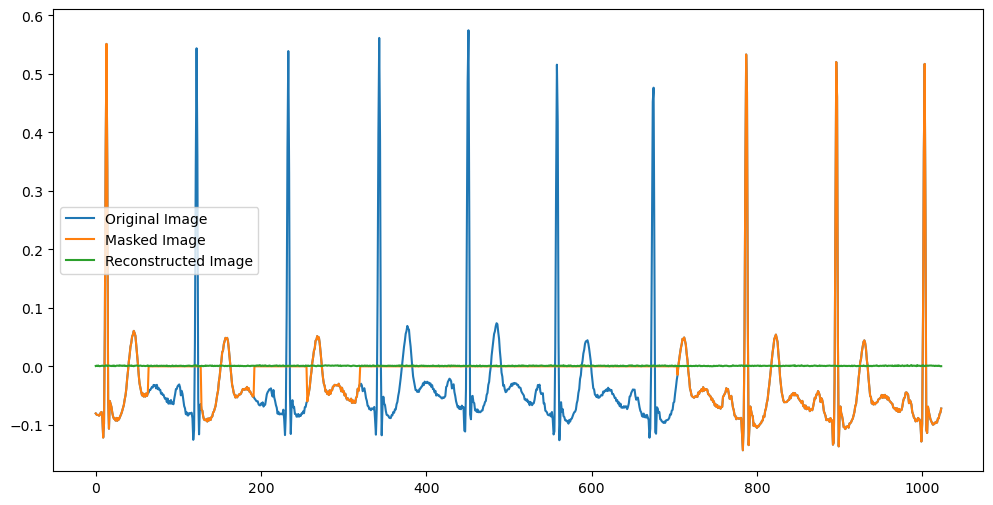

original image: (1024, 1)
masked image: (1024, 1)
reconstructed image: (1024, 1)
452/452 [==============================] - 29s 54ms/step - loss: 0.0355 - val_loss: 0.0320
Epoch 2/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0403 - val_loss: 0.0296
Epoch 3/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0402 - val_loss: 0.0333
Epoch 4/100
452/452 [==============================] - 35s 77ms/step - loss: 0.0400 - val_loss: 0.0324
Epoch 5/100
452/452 [==============================] - 24s 52ms/step - loss: 0.0402 - val_loss: 0.0313
Epoch 6/100
452/452 [==============================] - ETA: 0s - loss: 0.0406
Idx chosen: 775


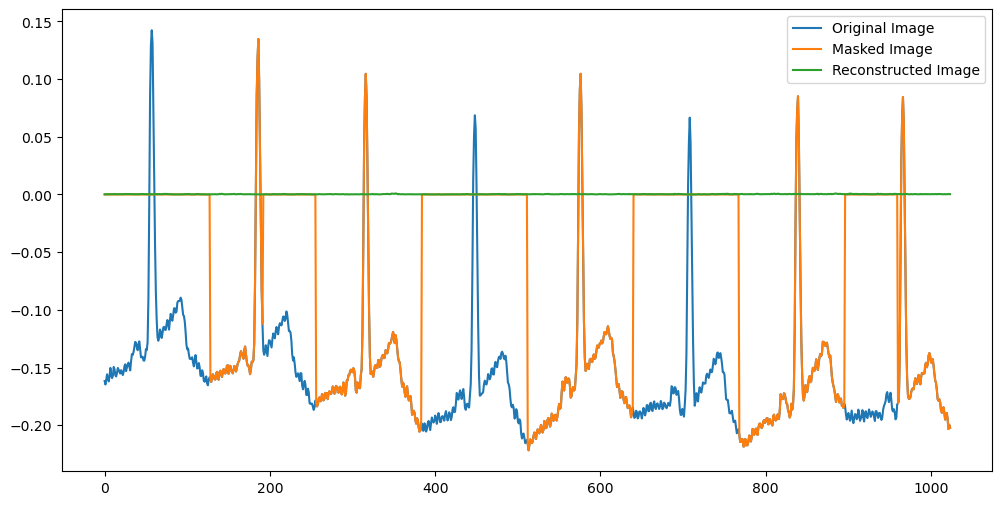

original image: (1024, 1)
masked image: (1024, 1)
reconstructed image: (1024, 1)
452/452 [==============================] - 24s 53ms/step - loss: 0.0406 - val_loss: 0.0312
Epoch 7/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0403 - val_loss: 0.0332
Epoch 8/100
452/452 [==============================] - 23s 51ms/step - loss: 0.0405 - val_loss: 0.0343
Epoch 9/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0406 - val_loss: 0.0320
Epoch 10/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0394 - val_loss: 0.0232
Epoch 11/100
451/452 [============================>.] - ETA: 0s - loss: 0.0400
Idx chosen: 34


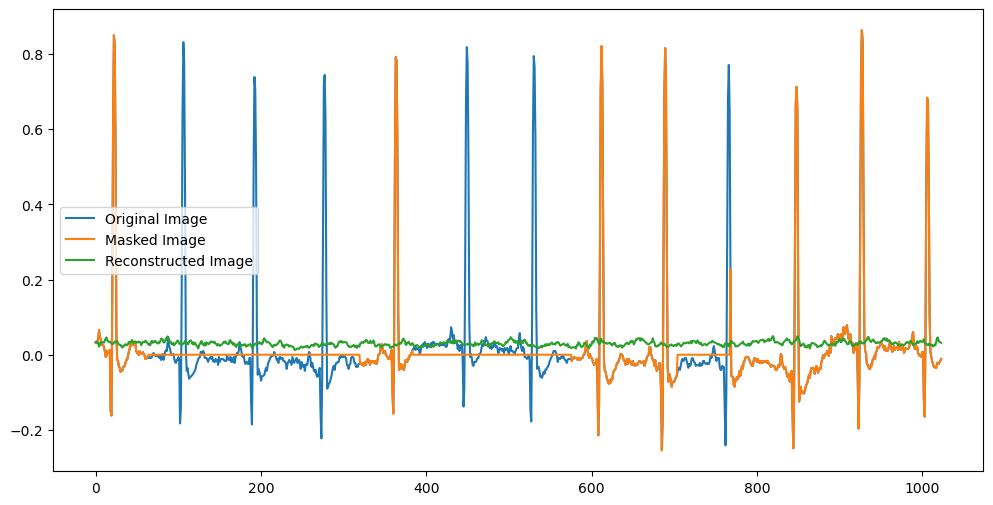

original image: (1024, 1)
masked image: (1024, 1)
reconstructed image: (1024, 1)
452/452 [==============================] - 24s 54ms/step - loss: 0.0400 - val_loss: 0.0259
Epoch 12/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0394 - val_loss: 0.0302
Epoch 13/100
452/452 [==============================] - 24s 52ms/step - loss: 0.0394 - val_loss: 0.0284
Epoch 14/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0396 - val_loss: 0.0317
Epoch 15/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0399 - val_loss: 0.0320
Epoch 16/100
451/452 [============================>.] - ETA: 0s - loss: 0.0405
Idx chosen: 205


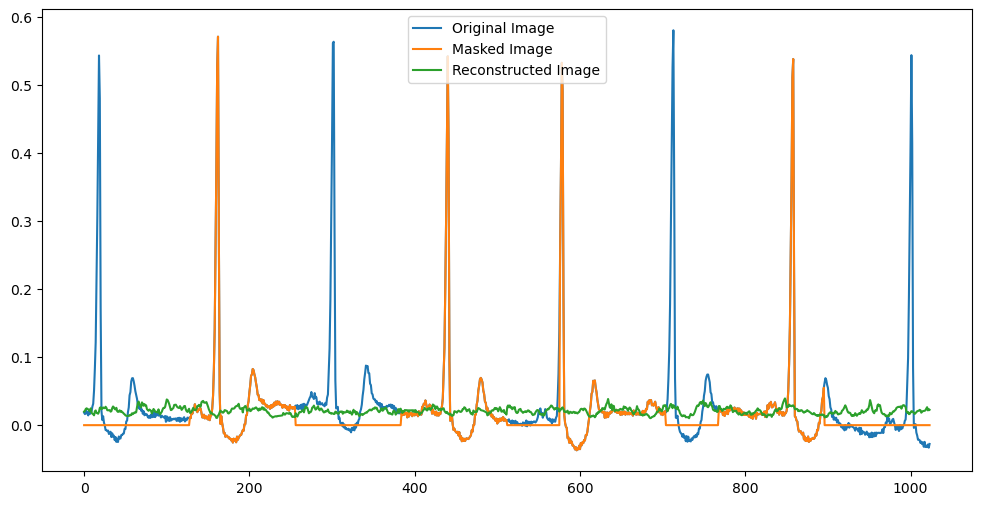

original image: (1024, 1)
masked image: (1024, 1)
reconstructed image: (1024, 1)
452/452 [==============================] - 24s 53ms/step - loss: 0.0405 - val_loss: 0.0272
Epoch 17/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0402 - val_loss: 0.0273
Epoch 18/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0403 - val_loss: 0.0305
Epoch 19/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0398 - val_loss: 0.0228
Epoch 20/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0398 - val_loss: 0.0284
Epoch 21/100
451/452 [============================>.] - ETA: 0s - loss: 0.0394
Idx chosen: 1104


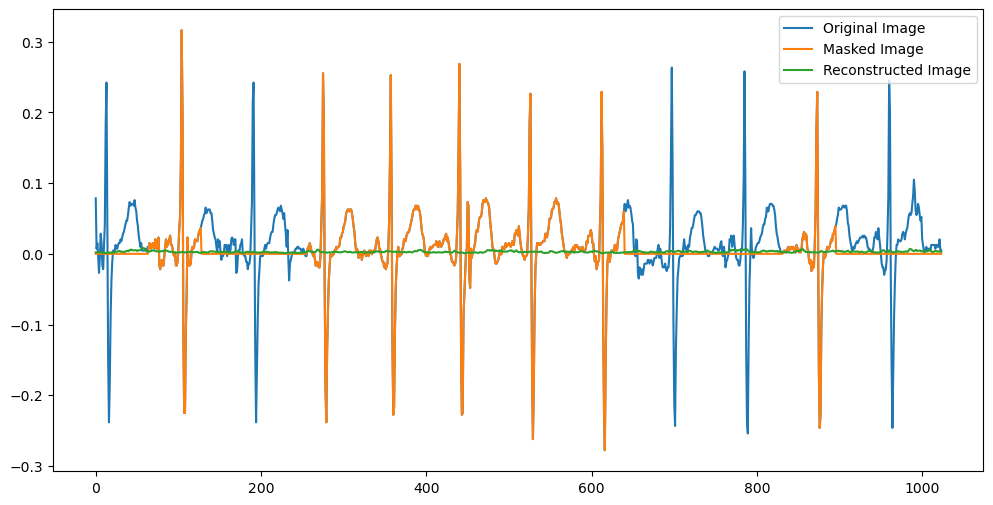

original image: (1024, 1)
masked image: (1024, 1)
reconstructed image: (1024, 1)
452/452 [==============================] - 24s 53ms/step - loss: 0.0394 - val_loss: 0.0332
Epoch 22/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0376 - val_loss: 0.0285
Epoch 23/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0383 - val_loss: 0.0235
Epoch 24/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0388 - val_loss: 0.0270
Epoch 25/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0383 - val_loss: 0.0224
Epoch 26/100
451/452 [============================>.] - ETA: 0s - loss: 0.0383
Idx chosen: 1411


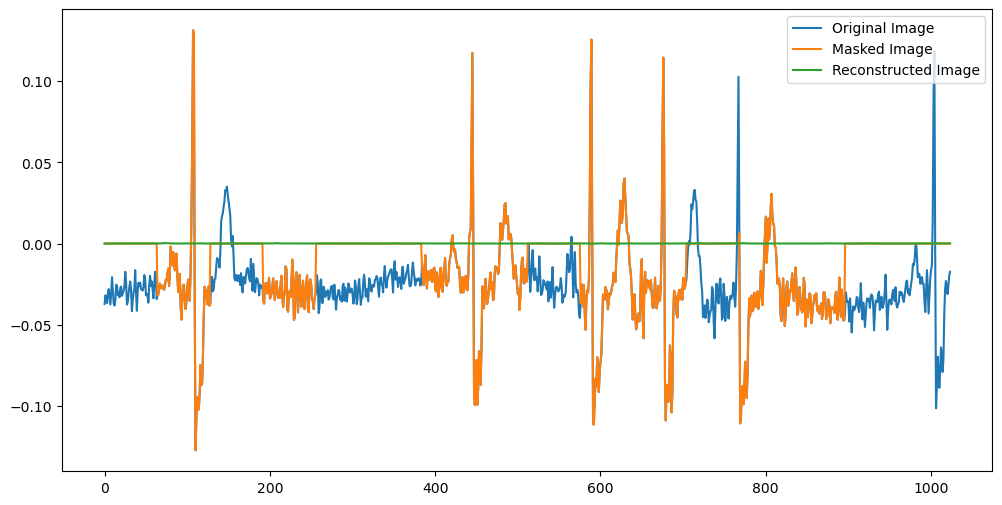

original image: (1024, 1)
masked image: (1024, 1)
reconstructed image: (1024, 1)
452/452 [==============================] - 24s 53ms/step - loss: 0.0383 - val_loss: 0.0201
Epoch 27/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0383 - val_loss: 0.0234
Epoch 28/100
452/452 [==============================] - 22s 50ms/step - loss: 0.0385 - val_loss: 0.0229
Epoch 29/100
452/452 [==============================] - 22s 49ms/step - loss: 0.0391 - val_loss: 0.0264
Epoch 30/100
452/452 [==============================] - 22s 49ms/step - loss: 0.0394 - val_loss: 0.0208
Epoch 31/100
451/452 [============================>.] - ETA: 0s - loss: 0.0390
Idx chosen: 1025


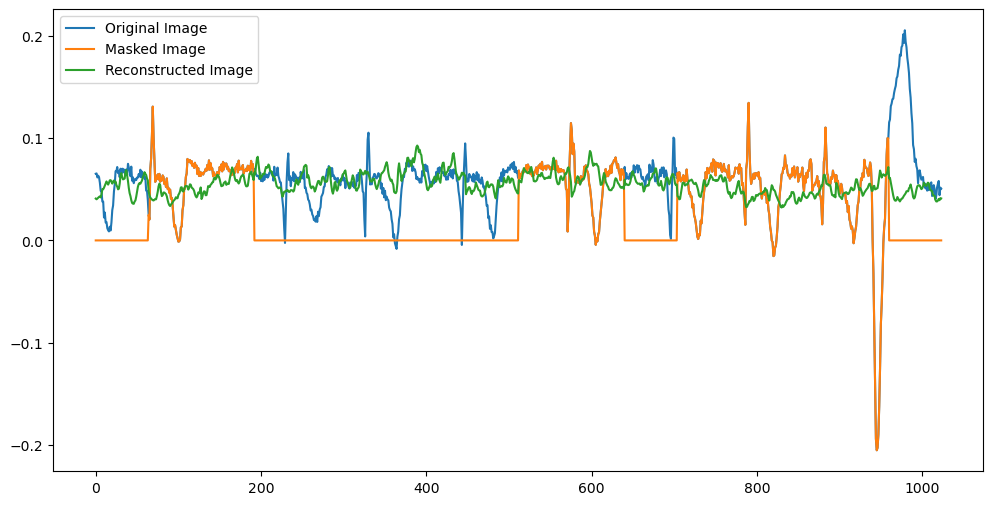

original image: (1024, 1)
masked image: (1024, 1)
reconstructed image: (1024, 1)
452/452 [==============================] - 23s 51ms/step - loss: 0.0390 - val_loss: 0.0266
Epoch 32/100
452/452 [==============================] - 23s 50ms/step - loss: 0.0380 - val_loss: 0.0141
Epoch 33/100
452/452 [==============================] - 23s 50ms/step - loss: 0.0389 - val_loss: 0.0208
Epoch 34/100
452/452 [==============================] - 23s 51ms/step - loss: 0.0390 - val_loss: 0.0231
Epoch 35/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0387 - val_loss: 0.0208
Epoch 36/100
452/452 [==============================] - ETA: 0s - loss: 0.0372
Idx chosen: 1021


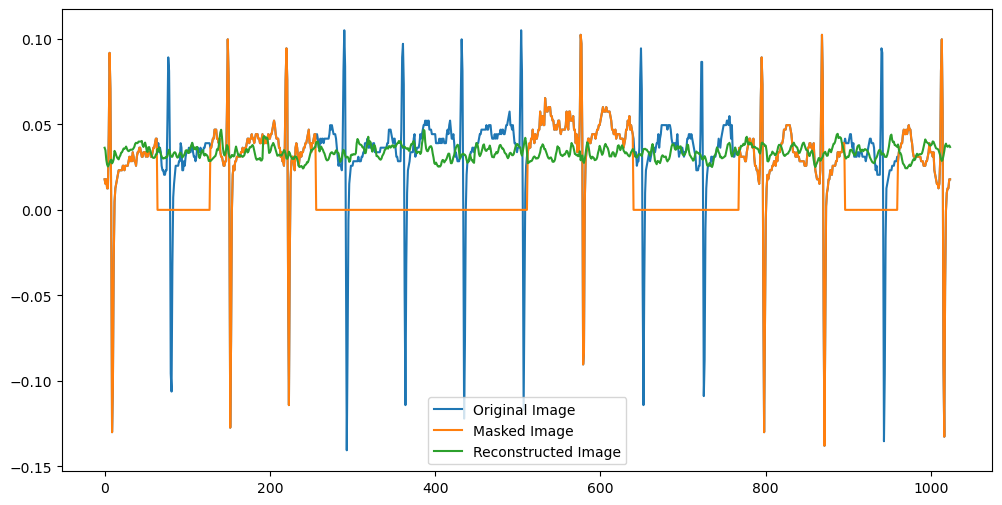

original image: (1024, 1)
masked image: (1024, 1)
reconstructed image: (1024, 1)
452/452 [==============================] - 24s 54ms/step - loss: 0.0372 - val_loss: 0.0203
Epoch 37/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0380 - val_loss: 0.0294
Epoch 38/100
452/452 [==============================] - 24s 52ms/step - loss: 0.0386 - val_loss: 0.0297
Epoch 39/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0388 - val_loss: 0.0282
Epoch 40/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0393 - val_loss: 0.0320
Epoch 41/100
452/452 [==============================] - ETA: 0s - loss: 0.0370
Idx chosen: 1413


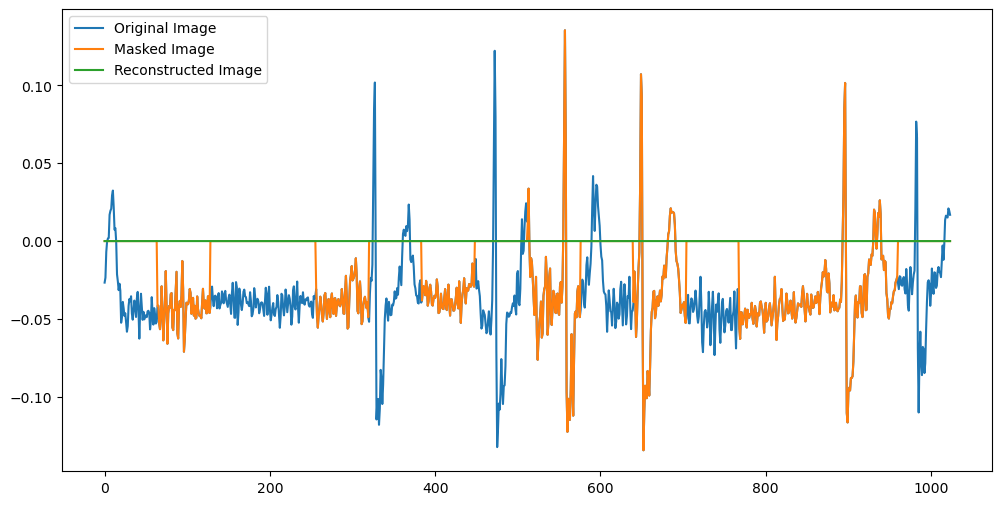

original image: (1024, 1)
masked image: (1024, 1)
reconstructed image: (1024, 1)
452/452 [==============================] - 24s 53ms/step - loss: 0.0370 - val_loss: 0.0311
Epoch 42/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0394 - val_loss: 0.0308
Epoch 43/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0393 - val_loss: 0.0314
Epoch 44/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0386 - val_loss: 0.0305
Epoch 45/100
452/452 [==============================] - 23s 52ms/step - loss: 0.0397 - val_loss: 0.0329
Epoch 46/100
452/452 [==============================] - ETA: 0s - loss: 0.0396
Idx chosen: 565


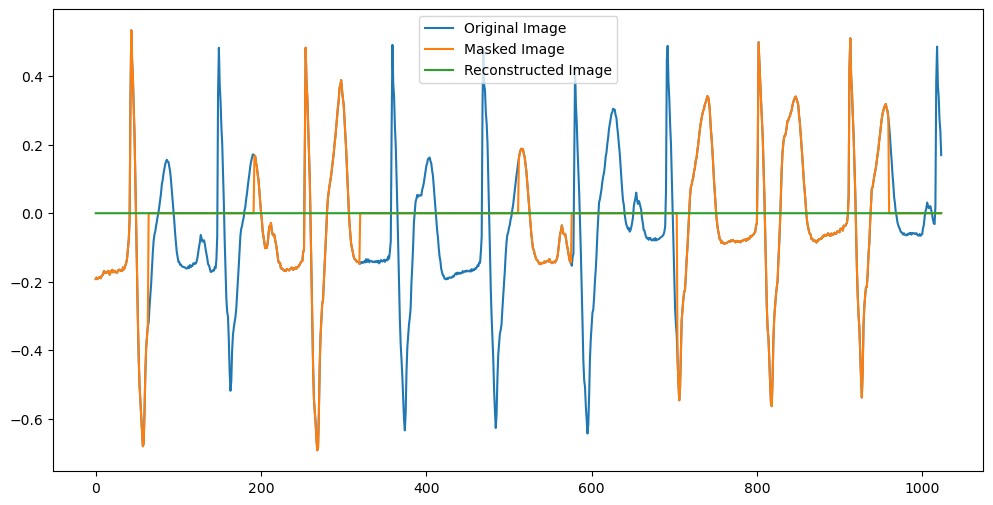

original image: (1024, 1)
masked image: (1024, 1)
reconstructed image: (1024, 1)
452/452 [==============================] - 24s 53ms/step - loss: 0.0396 - val_loss: 0.0322
Epoch 47/100
452/452 [==============================] - 24s 52ms/step - loss: 0.0400 - val_loss: 0.0312
Epoch 48/100
267/452 [================>.............] - ETA: 8s - loss: 0.0415

In [ ]:
optimizer = keras.optimizers.Adam(
    learning_rate=1e-3, weight_decay=WEIGHT_DECAY
)
train_callbacks = [TrainMonitor(epoch_interval=5)]

# Compile and pretrain the model.
mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)
history = mae_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=train_callbacks,
)

# Measure its performance.
loss, mae = mae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")